<a href="https://colab.research.google.com/github/eylulpelinkilic/Clash-Royale-DSA210-Project/blob/main/Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel("matches_50_players_prep (2).xlsx")

Null Hypothesis (H0):
The average elixir cost is the same for winning and losing matches.

Alternative Hypothesis (H1):
The average elixir cost is lower in winning matches than in losing matches.

In [6]:
from scipy.stats import mannwhitneyu

win_elixir = df[df['win'] == 1]['team_avg_elixir']
lose_elixir = df[df['win'] == 0]['team_avg_elixir']

# alternative='less' dersek, ilk grup medianı (win_elixir) daha küçük mü diye test eder
stat, p_value = mannwhitneyu(win_elixir, lose_elixir, alternative='less')

print(f"Mann-Whitney U statistic: {stat:.5f}")
print(f"P-value (one-tailed): {p_value:.5f}")

if p_value < 0.05:
    print("Reject H0: Winning matches have significantly lower average elixir cost than losing matches.")
else:
    print("Fail to reject H0: No significant evidence that winning matches have lower average elixir cost.")


Mann-Whitney U statistic: 256306.50000
P-value (one-tailed): 0.00004
Reject H0: Winning matches have significantly lower average elixir cost than losing matches.


Null Hypothesis (H0):
The variable team_cardtype_variety is normally distributed.

Alternative Hypothesis (H1):
The variable team_cardtype_variety is not normally distributed.

Shapiro-Wilk Test Statistic: 0.9027, p-value: 0.0000
Data is likely NOT normally distributed (reject H0)


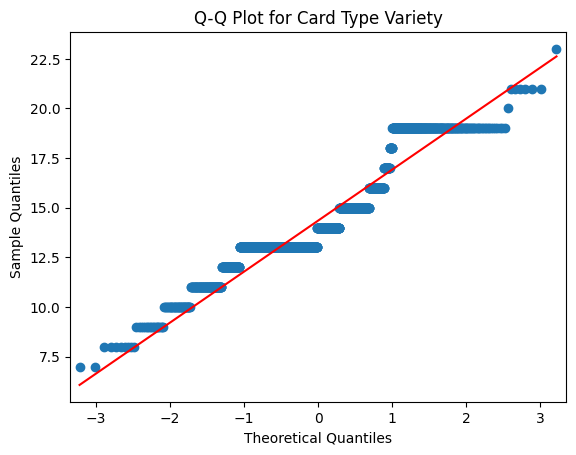

In [11]:

# Shapiro-Wilk testi
stat, p_value = stats.shapiro(df['team_cardtype_variety'])
print(f'Shapiro-Wilk Test Statistic: {stat:.4f}, p-value: {p_value:.4f}')
if p_value > 0.05:
    print("Data is likely normally distributed (fail to reject H0)")
else:
    print("Data is likely NOT normally distributed (reject H0)")

# Q-Q plot
sm.qqplot(df['team_cardtype_variety'], line='s')
plt.title('Q-Q Plot for Card Type Variety')
plt.show()


Null Hypothesis (H0):
There is no significant difference in win rates among decks with low, medium, and high card type variety.

Alternative Hypothesis (H1):
At least one group (low, medium, or high card type variety) has a significantly different win rate compared to the others.

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import scikit_posthocs as sp

# 1. Group data by deck and calculate total matches and wins
deck_stats = df.groupby('team_deck').agg(
    total_matches=('win', 'count'),
    wins=('win', 'sum')
).reset_index()

# 2. Calculate win rate
deck_stats['win_rate'] = deck_stats['wins'] / deck_stats['total_matches']

# 3. Identify card type columns (starting with 'team_n_')
card_type_cols = [col for col in df.columns if col.startswith('team_n_')]

# 4. Calculate average card type usage per deck
deck_cardtype_avg = df.groupby('team_deck')[card_type_cols].mean()

# 5. Calculate card type variety (number of types with average > 0)
deck_cardtype_avg['cardtype_variety'] = deck_cardtype_avg.gt(0).sum(axis=1)

# 6. Merge card type variety into deck_stats
deck_stats = deck_stats.merge(deck_cardtype_avg[['cardtype_variety']], left_on='team_deck', right_index=True)

# 7. Create groups based on cardtype_variety quartiles
deck_stats['variety_group'] = pd.qcut(deck_stats['cardtype_variety'], q=3, labels=['Low', 'Medium', 'High'], duplicates='drop')

# 8. Prepare data for Kruskal-Wallis test
grouped_winrates = [deck_stats[deck_stats['variety_group'] == grp]['win_rate'] for grp in ['Low', 'Medium', 'High']]

# 9. Perform Kruskal-Wallis test
stat, p = kruskal(*grouped_winrates)
print(f"Kruskal-Wallis statistic: {stat:.4f}, p-value: {p:.4f}")

if p < 0.05:
    print("Reject H0: Significant difference in win rates among groups.")
    # 10. Post-hoc Dunn test
    posthoc = sp.posthoc_dunn(deck_stats, val_col='win_rate', group_col='variety_group', p_adjust='bonferroni')
    print("Post-hoc Dunn test p-values:")
    print(posthoc)
else:
    print("Fail to reject H0: No significant difference in win rates among groups.")

Kruskal-Wallis statistic: 14.1977, p-value: 0.0008
Reject H0: Significant difference in win rates among groups.
Post-hoc Dunn test p-values:
             Low    Medium      High
Low     1.000000  0.146479  0.000792
Medium  0.146479  1.000000  1.000000
High    0.000792  1.000000  1.000000


H0: The combination of "tank" and "support" card types does not affect the win rate.

H1: The combination of "tank" and "support" card types increases the win rate.

In [22]:
df['combo_tank_support_present'] = ((df['team_n_tank'] > 0) & (df['team_n_support'] > 0)).astype(int)

contingency_table = pd.crosstab(df['combo_tank_support_present'], df['win'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2:.4f}, p-value: {p:.4f}")

if p < 0.05:
    print("Reject H0: There is an association between Tank+Support combo and match outcome.")
else:
    print("Fail to reject H0: No significant association between Tank+Support combo and match outcome.")


Chi-square statistic: 7.0264, p-value: 0.0080
Reject H0: There is an association between Tank+Support combo and match outcome.
